# Partie Densité

Dans cette partie nous avons pour objectif de créer des cartes montrant la densité de parties (arrondissements, parties, zones iris) de Paris. 

In [4]:
from geoclass import GeoDataParis
from annexfunctions import (visualiser_maillages, aggregate_by_geographic_division,
                           calculate_density, calculate_corrected_density, visualize_aggregated_data,
                           load_non_buildable_areas, load_all_nonbuildable_areas, create_buildable_geometries,
                           create_buildable_geodataframe, parse_geometry)
import pandas as pd
import geopandas as gpd
import requests
from io import BytesIO
from decoupagegeo import *

## 1) Découper Paris

Nous avons sur opendatasoft et le site de paris des csv chargeable par URL contenant les divisions de Paris nous intéressant. Afin de rendre la suite du projet plus ergonomique nous avons crée une classe GeoDataParis nous permettant de charger ces divisions. Le code est consultatble dans le document `geoclass.py`


Voici un extrait de la classe avec un chargement:
```python
class GeoDataParis:
    """Manages loading and caching of Paris geographical data layers."""

    def __init__(self):
        self.data = {}

    def load_arrondissements(self):
        """Load Paris arrondissements."""
        if 'arrondissements' not in self.data:
            url = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/arrondissements/exports/geojson"
            self.data['arrondissements'] = gpd.read_file(url)
        return self.data['arrondissements']
```

Skipping field reg_code: unsupported OGR type: 5
Skipping field reg_name: unsupported OGR type: 5
Skipping field dep_code: unsupported OGR type: 5
Skipping field dep_name: unsupported OGR type: 5
Skipping field arrdep_code: unsupported OGR type: 5
Skipping field arrdep_name: unsupported OGR type: 5
Skipping field bv2022_code: unsupported OGR type: 5
Skipping field bv2022_name: unsupported OGR type: 5
Skipping field epci_code: unsupported OGR type: 5
Skipping field epci_name: unsupported OGR type: 5
Skipping field com_code: unsupported OGR type: 5
Skipping field com_name: unsupported OGR type: 5
Skipping field com_arm_code: unsupported OGR type: 5
Skipping field com_arm_name: unsupported OGR type: 5
Skipping field iris_code: unsupported OGR type: 5
Skipping field iris_name: unsupported OGR type: 5


Visualization saved: maillages_paris_complet.png


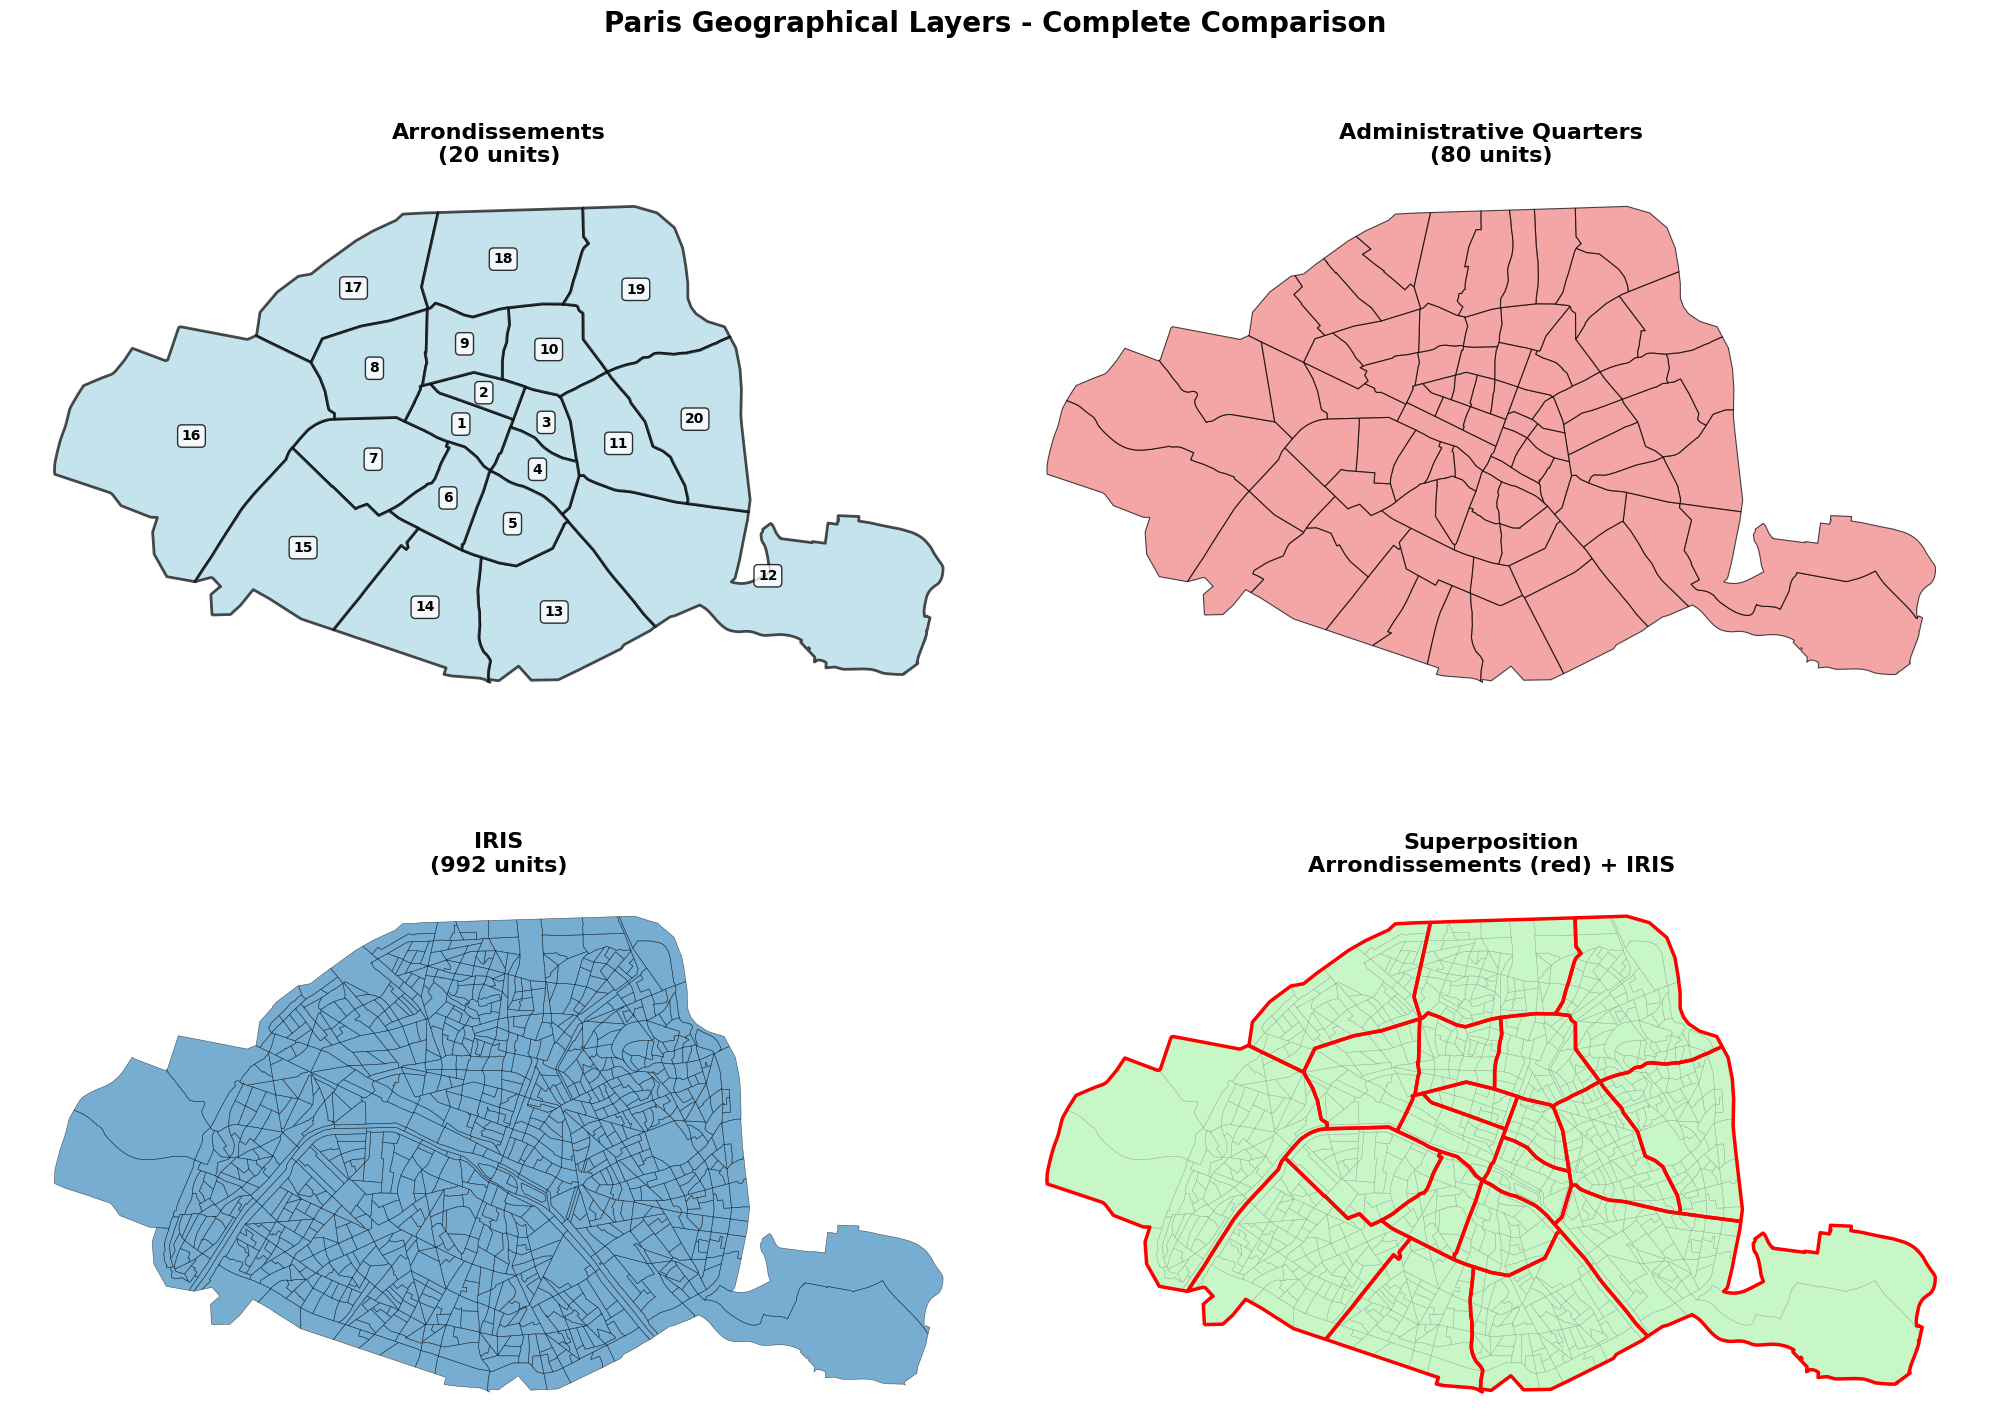

In [2]:
from annexfunctions import visualiser_maillages

geo = GeoDataParis()
geo_data = geo.load_all()
visualiser_maillages(geo_data)

## 2) Densité

Nous pouvons ensuite charger les données des bâtiments parisiens, nous avons environ 360 000 entrées

In [8]:
buildings = load_building_data()
buildings.head()

Loading building data...
Loaded 361702 building records
Converted to 361700 valid building polygons


,geom_x_y,geom,C_NAT_B,L_NAT_B,C_SRC,L_SRC,M2,NB_PL,M2_PL_TOT,B_RDC,C_PLAN_H_I,Y,L_PLAN_H_I,X,D_CRE,L_B_U,D_MAJ,N_AR,L_PLAN_H,H_ET_MAX,N_QU,OBJECTID,Identifiant s?quentiel,Arrondissement contenant le bati,Parcelle contenant le bati,Quartier contenant le bati,st_area(shape),st_perimeter(shape),geometry
0,"48.828418822496616, 2.316867807934339","{""coordinates"": [[[2.3168431350090235, 48.8284...",V,Volume bâti simple,T,Fiche parcellaire et terrain certifié,112.310097,6.0,673.860582,1.0,3.0,125326.399390,Bâti de 4 à 8 étages,598556.838689,1910-03-01T01:09:21+01:00,NaN,2010-07-21T04:00:00+02:00,14,R+5,5.0,56.0,170478,750169835,750000014,750036552.0,750000056.0,112.293241,43.061478,"POLYGON ((649847.804 6858931.184, 649851.117 6..."
1,"48.83018006870642, 2.3136898923086644","{""coordinates"": [[[2.3136894517081377, 48.8302...",V,Volume bâti simple,T,Fiche parcellaire et terrain certifié,120.938396,7.0,846.568770,1.0,3.0,125523.242549,Bâti de 4 à 8 étages,598322.771045,1907-03-01T01:09:21+01:00,NaN,2010-07-21T04:00:00+02:00,14,R+6,6.0,56.0,170517,750169874,750000014,750036372.0,750000056.0,120.920750,54.726740,"POLYGON ((649617.996 6859129.41, 649624.517 68..."
2,"48.830278936020704, 2.314432328773298","{""coordinates"": [[[2.3144373021551994, 48.8303...",V,Volume bâti simple,T,Fiche parcellaire et terrain certifié,11.049983,1.0,11.049983,1.0,1.0,125533.318138,Bâti à rez-de-chaussée,598378.107601,1904-03-01T01:09:21+01:00,NaN,2010-07-21T04:00:00+02:00,14,R,0.0,56.0,170523,750169880,750000014,750035695.0,750000056.0,11.048420,13.625554,"POLYGON ((649672.942 6859134.466, 649674.933 6..."
3,"48.83196784506646, 2.315021516681791","{""coordinates"": [[[2.3149283207657563, 48.8320...",V,Volume bâti simple,T,Fiche parcellaire et terrain certifié,85.053946,1.0,85.053946,1.0,1.0,125720.660979,Bâti à rez-de-chaussée,598421.944032,1923-12-01T01:00:00+01:00,NaN,2010-07-21T04:00:00+02:00,14,R,0.0,56.0,170578,750169935,750000014,750037102.0,750000056.0,85.041677,47.524146,"POLYGON ((649710.659 6859326.889, 649714.63 68..."
4,"48.831880015220186, 2.3234625883325797","{""coordinates"": [[[2.3234586318006825, 48.8318...",V,Volume bâti simple,T,Fiche parcellaire et terrain certifié,2.352368,1.0,2.352368,1.0,1.0,125711.187489,Bâti à rez-de-chaussée,599041.081945,2010-07-21T04:00:00+02:00,NaN,2010-07-21T04:00:00+02:00,14,R,0.0,56.0,170591,750169948,750000014,750036044.0,750000056.0,2.352041,6.253311,"POLYGON ((650336.694 6859305.411, 650337.872 6..."


Nous pouvons voir dans ces données une colonne M2 PL TOT qui correspond au nombre de m² bâtis en comptant les étages. Cette donnée nous servira de base pour créer les cartes de densités.

**Attention le prochain bloc de code crée les carets de densités et prends quelques minutes à s'exécuter**

In [9]:
print("=" * 60)
print("PARIS BUILDING DENSITY maps")
print("=" * 60)

# Initialize results dictionary
results = {
    'arrondissements': {},
    'quartiers': {},
    'iris': {}
}


# Load building data
print("\n2. Loading building data...")
buildings = load_building_data()

# Load non-buildable areas
print("\n3. Loading non-buildable areas...")
non_buildable = load_non_buildable_areas()

# Generate all density maps
print("\n4. Generating building density maps...")

for geo_level in ['arrondissements', 'quartiers', 'iris']:
    print(f"\n--- {geo_level.title()} ---")

    # Get appropriate geographic divisions
    geo_divisions = geo_data[geo_level]

    # Create raw density map
    print("Creating raw density map...")
    raw_data, _ = create_building_density_map(buildings, geo_divisions, geo_level)
    results[geo_level]['raw'] = raw_data

    # Create corrected density map (excluding water + railways)
    print("Creating corrected density map...")
    corrected_data, _ = create_corrected_building_density_map(buildings, geo_divisions, non_buildable, geo_level)
    results[geo_level]['corrected'] = corrected_data

    # Create ultra-corrected density map (excluding water + railways + green spaces)
    print("Creating ultra-corrected density map...")
    ultra_corrected_data, _ = create_ultra_corrected_building_density_map(buildings, geo_divisions, geo_level)
    results[geo_level]['ultra_corrected'] = ultra_corrected_data

print("\n" + "=" * 60)
print("COMPLETED: All building density maps created")
print("Raw density maps:")
print("- building_density_arrondissements.html")
print("- building_density_quartiers.html")
print("- building_density_iris.html")
print("\nCorrected density maps (excluding water & railways):")
print("- building_density_corrected_arrondissements.html")
print("- building_density_corrected_quartiers.html")
print("- building_density_corrected_iris.html")
print("\nUltra-corrected density maps (excluding water + railways + green spaces):")
print("- building_density_ultra_corrected_arrondissements.html")
print("- building_density_ultra_corrected_quartiers.html")
print("- building_density_ultra_corrected_iris.html")
print("=" * 60)

PARIS BUILDING DENSITY maps

2. Loading building data...
Loading building data...
Loaded 361702 building records
Converted to 361700 valid building polygons

3. Loading non-buildable areas...
Loading non-buildable areas...
  Loading water bodies...
  Loaded 58 water body geometries
  Loading railways...
  Loaded 295 railway geometries
  Creating union of non-buildable areas...
  Non-buildable areas loaded: 1 features

4. Generating building density maps...

--- Arrondissements ---
Creating raw density map...
Processing arrondissements...
Step 1: Aggregating building surface...
Step 2: Calculating density...
Average density: 1.96 m²/m²
Step 3: Creating interactive map...
Interactive map saved to Data/building_density_arrondissements.html
Creating corrected density map...
Processing corrected arrondissements...
Step 1: Calculating buildable areas...
  Average buildable percentage: 94.3%
Step 2: Aggregating building surface by geographic divisions...
Step 3: Calculating corrected density.

**Le prochain bloc de code ouvre un NAVIGATEUR WEB avec une carte interactive.**

In [37]:
import webbrowser
import os

# Open the HTML file in your default browser
webbrowser.open('file://' + os.path.realpath('Data/building_density_arrondissements.html'))

True

Cette carte nous montre les arrondissements de Paris, et leur densité, ie m² de bâti par m² de suface au sol. On s'attend bien a avoir des valeurs au dessus de 1 par la prise en compte des étages de bâti.

En revanche, pour puvoir réellement comparer les arrondissement ou quartiers de la ville nous devons corriger ccette densité. En effet, il y a des zones non batissables: les cours d'eau, les voies ferrées et les espaces verts. Pour appliquer ces corrections, nous avons importé les bases de données correspondantes et nous avons suivi la méthodologie suivante:
- Regrouper tous les espaces non batissables dans une grosse géométrie complexe
- Faire l'intersection de chaque partie (arrondissement, quartier, iris) avec celle-ci
- Calculer la surface non batissable et la retrancher à la surface totale
- Recalculer la densité corrigée

une fois ceci fait nous avons ces résultats:

**Attention, les 3 prochaines cellules de code ouvrent des navigateurs internet pour voir des cartes intéractives**

In [38]:
import webbrowser
import os

# Open the HTML file in your default browser
webbrowser.open('file://' + os.path.realpath('Data/building_density_ultra_corrected_arrondissements.html'))

True

In [39]:
import webbrowser
import os

# Open the HTML file in your default browser
webbrowser.open('file://' + os.path.realpath('Data/building_density_ultra_corrected_quartiers.html'))

True

In [40]:
import webbrowser
import os

# Open the HTML file in your default browser
webbrowser.open('file://' + os.path.realpath('Data/building_density_ultra_corrected_iris.html'))

True

Nous vous invitons à explorer ces cartes et à regarder les différents filtres dynamiques et descriptions en survolant les cases.

## 3) Analyse des données

Dans cette partie nous allons présenter les données de densité que nous avons crées à partir des différentes bases de données. La méthodologie présentée en partie 2 nous permet également de créer trois `DataFrame`, un pour chaque découpage de Paris, dans lesquels nous avons renseigné la surface au sol, la surface non batissable, les différentes densités avec plus ou moins de correction (points d'eau, espaces verts, voies ferrées).

In [12]:
import pandas as pd
from pathlib import Path
from decoupagegeo import GeoDataParis, load_building_data, load_non_buildable_areas, load_all_nonbuildable_areas
from annexfunctions import aggregate_by_geographic_division, calculate_density, calculate_corrected_density, create_buildable_geometries
import extract_density_dataframes

**Attention le brochain bloc de code crée les DataFrame et les sauvegarde en csv, ce qui prend environ 5 minutes**

In [13]:
results = extract_density_dataframes.main()

PARIS BUILDING DENSITY DATA EXTRACTION
Creating Arrondissements DataFrame...


Skipping field reg_code: unsupported OGR type: 5
Skipping field reg_name: unsupported OGR type: 5
Skipping field dep_code: unsupported OGR type: 5
Skipping field dep_name: unsupported OGR type: 5
Skipping field arrdep_code: unsupported OGR type: 5
Skipping field arrdep_name: unsupported OGR type: 5
Skipping field bv2022_code: unsupported OGR type: 5
Skipping field bv2022_name: unsupported OGR type: 5
Skipping field epci_code: unsupported OGR type: 5
Skipping field epci_name: unsupported OGR type: 5
Skipping field com_code: unsupported OGR type: 5
Skipping field com_name: unsupported OGR type: 5
Skipping field com_arm_code: unsupported OGR type: 5
Skipping field com_arm_name: unsupported OGR type: 5
Skipping field iris_code: unsupported OGR type: 5
Skipping field iris_name: unsupported OGR type: 5


Loading building data...
Loaded 361702 building records
Converted to 361700 valid building polygons
Loading non-buildable areas...
  Loading water bodies...
  Loaded 58 water body geometries
  Loading railways...
  Loaded 295 railway geometries
  Creating union of non-buildable areas...
  Non-buildable areas loaded: 1 features
Loading all non-buildable areas (water + railways + green spaces)...
Loading non-buildable areas...
  Loading water bodies...
  Loaded 58 water body geometries
  Loading railways...
  Loaded 295 railway geometries
  Creating union of non-buildable areas...
  Non-buildable areas loaded: 1 features
Loading green spaces...
  Loading roadway green spaces...
  Loaded 983 roadway green space geometries
  Loading green spaces and assimilated...
  Dataset 2 columns: ['Identifiant espace vert', "Nom de l'espace vert", "Typologie d'espace vert", 'Catégorie', 'Adresse - Numéro', 'Adresse - Complément', 'Adresse - type voie', 'Adresse - Libellé voie', 'Code postal', 'Surface

c:\Users\Gabriel\p4ds\extract_density_dataframes.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  arrondissements_with_areas['total_area_m2'] = arrondissements.geometry.area


  Processing raw density calculations...
  Processing corrected density calculations...
  Processing ultra_corrected density calculations...
Created arrondissements dataframe: 20 rows × 32 columns

Creating Quartiers DataFrame...


Skipping field reg_code: unsupported OGR type: 5
Skipping field reg_name: unsupported OGR type: 5
Skipping field dep_code: unsupported OGR type: 5
Skipping field dep_name: unsupported OGR type: 5
Skipping field arrdep_code: unsupported OGR type: 5
Skipping field arrdep_name: unsupported OGR type: 5
Skipping field bv2022_code: unsupported OGR type: 5
Skipping field bv2022_name: unsupported OGR type: 5
Skipping field epci_code: unsupported OGR type: 5
Skipping field epci_name: unsupported OGR type: 5
Skipping field com_code: unsupported OGR type: 5
Skipping field com_name: unsupported OGR type: 5
Skipping field com_arm_code: unsupported OGR type: 5
Skipping field com_arm_name: unsupported OGR type: 5
Skipping field iris_code: unsupported OGR type: 5
Skipping field iris_name: unsupported OGR type: 5


Loading building data...
Loaded 361702 building records
Converted to 361700 valid building polygons
Loading non-buildable areas...
  Loading water bodies...
  Loaded 58 water body geometries
  Loading railways...
  Loaded 295 railway geometries
  Creating union of non-buildable areas...
  Non-buildable areas loaded: 1 features
Loading all non-buildable areas (water + railways + green spaces)...
Loading non-buildable areas...
  Loading water bodies...
  Loaded 58 water body geometries
  Loading railways...
  Loaded 295 railway geometries
  Creating union of non-buildable areas...
  Non-buildable areas loaded: 1 features
Loading green spaces...
  Loading roadway green spaces...
  Loaded 983 roadway green space geometries
  Loading green spaces and assimilated...
  Dataset 2 columns: ['Identifiant espace vert', "Nom de l'espace vert", "Typologie d'espace vert", 'Catégorie', 'Adresse - Numéro', 'Adresse - Complément', 'Adresse - type voie', 'Adresse - Libellé voie', 'Code postal', 'Surface

c:\Users\Gabriel\p4ds\extract_density_dataframes.py:183: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  quartiers_with_areas['total_area_m2'] = quartiers.geometry.area


  Processing raw density calculations...
  Processing corrected density calculations...
  Processing ultra_corrected density calculations...
Created quartiers dataframe: 80 rows × 34 columns

Creating IRIS DataFrame...


Skipping field reg_code: unsupported OGR type: 5
Skipping field reg_name: unsupported OGR type: 5
Skipping field dep_code: unsupported OGR type: 5
Skipping field dep_name: unsupported OGR type: 5
Skipping field arrdep_code: unsupported OGR type: 5
Skipping field arrdep_name: unsupported OGR type: 5
Skipping field bv2022_code: unsupported OGR type: 5
Skipping field bv2022_name: unsupported OGR type: 5
Skipping field epci_code: unsupported OGR type: 5
Skipping field epci_name: unsupported OGR type: 5
Skipping field com_code: unsupported OGR type: 5
Skipping field com_name: unsupported OGR type: 5
Skipping field com_arm_code: unsupported OGR type: 5
Skipping field com_arm_name: unsupported OGR type: 5
Skipping field iris_code: unsupported OGR type: 5
Skipping field iris_name: unsupported OGR type: 5


Loading building data...
Loaded 361702 building records
Converted to 361700 valid building polygons
Loading non-buildable areas...
  Loading water bodies...
  Loaded 58 water body geometries
  Loading railways...
  Loaded 295 railway geometries
  Creating union of non-buildable areas...
  Non-buildable areas loaded: 1 features
Loading all non-buildable areas (water + railways + green spaces)...
Loading non-buildable areas...
  Loading water bodies...
  Loaded 58 water body geometries
  Loading railways...
  Loaded 295 railway geometries
  Creating union of non-buildable areas...
  Non-buildable areas loaded: 1 features
Loading green spaces...
  Loading roadway green spaces...
  Loaded 983 roadway green space geometries
  Loading green spaces and assimilated...
  Dataset 2 columns: ['Identifiant espace vert', "Nom de l'espace vert", "Typologie d'espace vert", 'Catégorie', 'Adresse - Numéro', 'Adresse - Complément', 'Adresse - type voie', 'Adresse - Libellé voie', 'Code postal', 'Surface

c:\Users\Gabriel\p4ds\extract_density_dataframes.py:328: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  iris_with_areas['total_area_m2'] = iris.geometry.area


  Processing raw density calculations...
  Processing corrected density calculations...
  Processing ultra_corrected density calculations...
Created IRIS dataframe: 992 rows × 38 columns

DATA EXTRACTION COMPLETE
Summary:
  Arrondissements: 20 zones × 32 features
  Quartiers: 80 zones × 34 features
  IRIS: 992 zones × 38 features
Saving dataframes to CSV...
Saved arrondissements: 20 rows × 32 columns
Saved quartiers: 80 rows × 34 columns
Saved IRIS: 992 rows × 38 columns

Files saved to 'data/' directory:
- paris_arrondissements_complete.csv/.parquet
- paris_quartiers_complete.csv/.parquet
- paris_iris_complete.csv/.parquet



In [15]:
df = pd.read_csv('Data/paris_arrondissements_complete.csv')
df.head()

,arr_id,arr_name,total_area_km2,buildable_percentage_corrected,excluded_percentage_corrected,buildable_area_km2_corrected,excluded_area_km2_corrected,buildable_percentage_ultra,excluded_percentage_ultra,buildable_area_km2_ultra,...,n_sq_co,surface,perimetre,geom_x_y,geometry,total_area_m2,buildable_area_m2_corrected,buildable_area_m2_ultra,excluded_area_m2_corrected,excluded_area_m2_ultra
0,17,17ème Ardt,6.952036e-10,96.5,3.5,5.472013,-5.472013,87.7,12.3,4.973438,...,750001537,5.668835e+06,10775.579516,"{ ""lon"": 2.3067769905744084, ""lat"": 48.8873265...","POLYGON ((2.295166912564455 48.8739552323989, ...",0.000695,5.472013e+06,4.973438e+06,-5.472013e+06,-4.973438e+06
1,3,3ème Ardt,1.435283e-10,100.0,0.0,1.170883,-1.170883,97.2,2.8,1.138505,...,750001537,1.170883e+06,4519.263648,"{ ""lon"": 2.3600009858976918, ""lat"": 48.8628723...","POLYGON ((2.363828096062926 48.86750443060333,...",0.000144,1.170883e+06,1.138505e+06,-1.170883e+06,-1.138505e+06
2,7,7ème Ardt,5.013024e-10,95.0,5.0,3.884271,-3.884271,82.7,17.3,3.383396,...,750001537,4.090057e+06,8099.424883,"{ ""lon"": 2.3121876953655494, ""lat"": 48.8561744...",POLYGON ((2.300883913456114 48.851176131084145...,0.000501,3.884271e+06,3.383396e+06,-3.884271e+06,-3.383396e+06
3,10,10ème Ardt,3.545589e-10,89.9,10.1,2.600045,-2.600045,87.4,12.6,2.528264,...,750001537,2.891739e+06,6739.375055,"{ ""lon"": 2.3607284878474522, ""lat"": 48.8761300...","POLYGON ((2.364685889119478 48.88436904340793,...",0.000355,2.600045e+06,2.528264e+06,-2.600045e+06,-2.528264e+06
4,18,18ème Ardt,7.354025e-10,83.1,16.9,4.983809,-4.983809,75.1,24.9,4.503168,...,750001537,5.996051e+06,9916.464176,"{ ""lon"": 2.3481605195620396, ""lat"": 48.8925692...","POLYGON ((2.365803615296344 48.88554429458038,...",0.000735,4.983809e+06,4.503168e+06,-4.983809e+06,-4.503168e+06


A partir de ces données nous pouvons faire des analyses statistiques et des visualisations plus approfondies

In [17]:
import data_visualization

In [18]:
data_visualization.main()

PARIS BUILDING DENSITY DATA VISUALIZATION
Loading dataframes...
Loaded: Arrondissements (20 zones), Quartiers (80 zones), IRIS (992 zones)

CREATING VISUALIZATIONS

Processing arrondissements...
Creating density distributions for arrondissements...
Creating area composition charts for arrondissements...
Creating correlation analysis for arrondissements...

Processing quartiers...
Creating density distributions for quartiers...
Creating area composition charts for quartiers...
Creating correlation analysis for quartiers...

Processing iris...
Creating density distributions for iris...
Creating area composition charts for iris...
Creating correlation analysis for iris...

Processing comparative analysis...
Creating comparative analysis plots...

Generating summary statistics...
Generating summary statistics...

BUILDING DENSITY ANALYSIS SUMMARY

ARRONDISSEMENTS:
  Zones: 20
  Mean Density: 2.382 m²/m²
  Median Density: 2.307 m²/m²
  Density Range: 1.896 - 3.255 m²/m²
  Mean Buildable Are

Le bloc précédent crée l'ensemble des visualisations que nous allons montrer. Nous les avons regroupés pour plus de concision. Comme pour toutes les sous parties traitant de la densité, nous vous invitons à consulter le scrypt .py correspondant pour plus de détails


**Key Metrics:**
- **Zones consdérées**: 1,092 (20 arrondissements + 80 quartiers + 992 IRIS)
- **moyenne de densité corrigée**: 2.4 m²/m² sur tout Paris
- **Les bornes de densité**: 0 - 9.1 m²/m² (IRIS)


In [19]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# Set up the notebook
plt.style.use('seaborn-v0_8')
pd.set_option('display.float_format', '{:.3f}'.format)

print("Paris Building Density Analysis - Key Insights")
print("=" * 50)

Paris Building Density Analysis - Key Insights


In [20]:
# Load the analysis dataframes
arr_df = pd.read_csv('data/paris_arrondissements_complete.csv')
quartiers_df = pd.read_csv('data/paris_quartiers_complete.csv')
iris_df = pd.read_csv('data/paris_iris_complete.csv')

print(f"Data loaded successfully:")
print(f"• Arrondissements: {arr_df.shape[0]} zones × {arr_df.shape[1]} features")
print(f"• Quartiers: {quartiers_df.shape[0]} zones × {quartiers_df.shape[1]} features")
print(f"• IRIS: {iris_df.shape[0]} zones × {iris_df.shape[1]} features")

Data loaded successfully:
• Arrondissements: 20 zones × 32 features
• Quartiers: 80 zones × 34 features
• IRIS: 992 zones × 38 features


### Statistiques descriptives

Voici un résumé des données en fonction du découpage de Paris

,Level,Zones,Mean_Density,Median_Density,Std_Density,Min_Density,Max_Density,Q25_Density,Q75_Density,Mean_Buildable_Pct
0,Arrondissements,20,2.382,2.307,0.397,1.896,3.255,2.063,2.608,80.805
1,Quartiers,80,2.398,2.333,0.483,1.463,3.552,2.045,2.684,83.051
2,IRIS,992,2.395,2.496,0.815,0.000,9.087,2.091,2.852,90.679


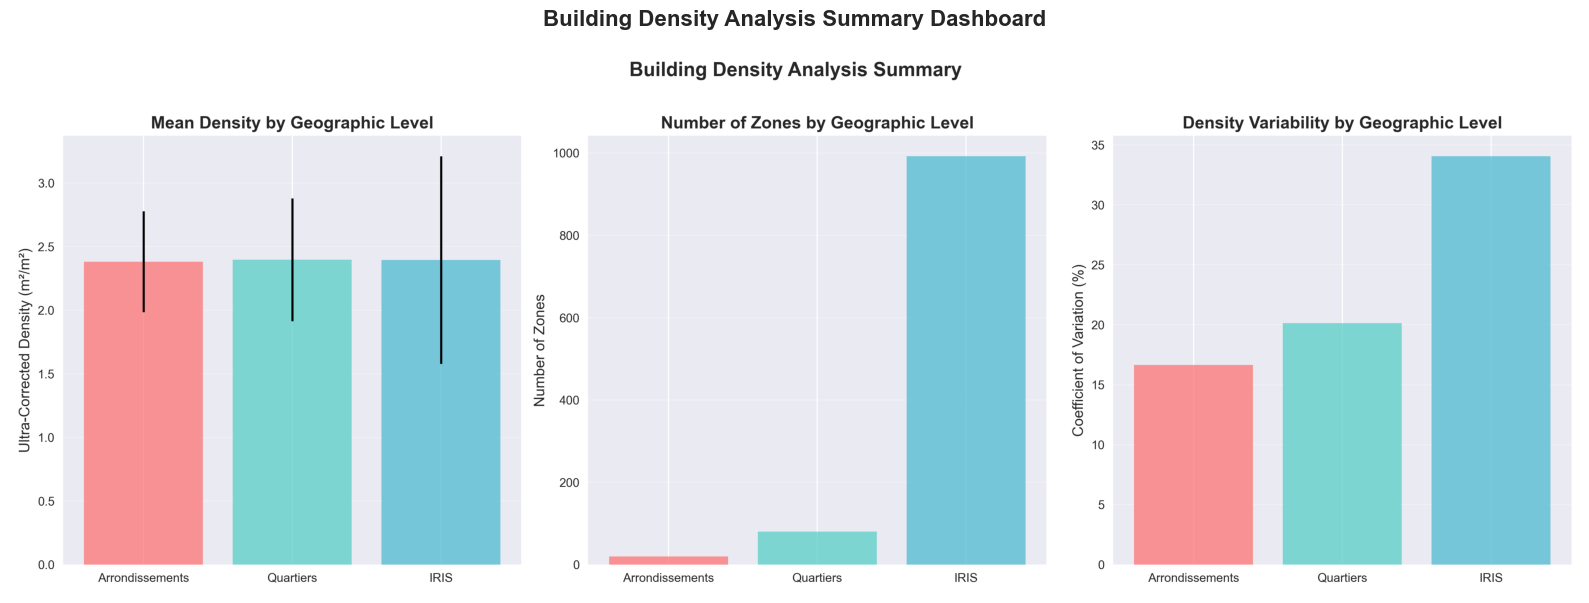

In [22]:
summary_df = pd.read_csv('plots/summary_statistics.csv')
display(summary_df)

img = mpimg.imread('plots/analysis_summary.png')
plt.figure(figsize=(16, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Building Density Analysis Summary Dashboard', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

**impact de l'échelle**: 

 Les iris montrent des niveaux très variables de densité, en particulier des valeurs très faibles (0) et une valeur extrême (9 m²/m² de surface au sol) ce qui montre une précision forte mais aussi un impact important de la correction de densité que nous avons choisie sur une échelle si granulaire

### Distribution de la densité du bâti

nous donnerons l'exemple des arrondissements, qui est plus parlant. les autres graphiques sont disponibles dans le sous dossier plot (généré par le script data_visualization.py) et nous comparons les trois distributions avec des violin plots.

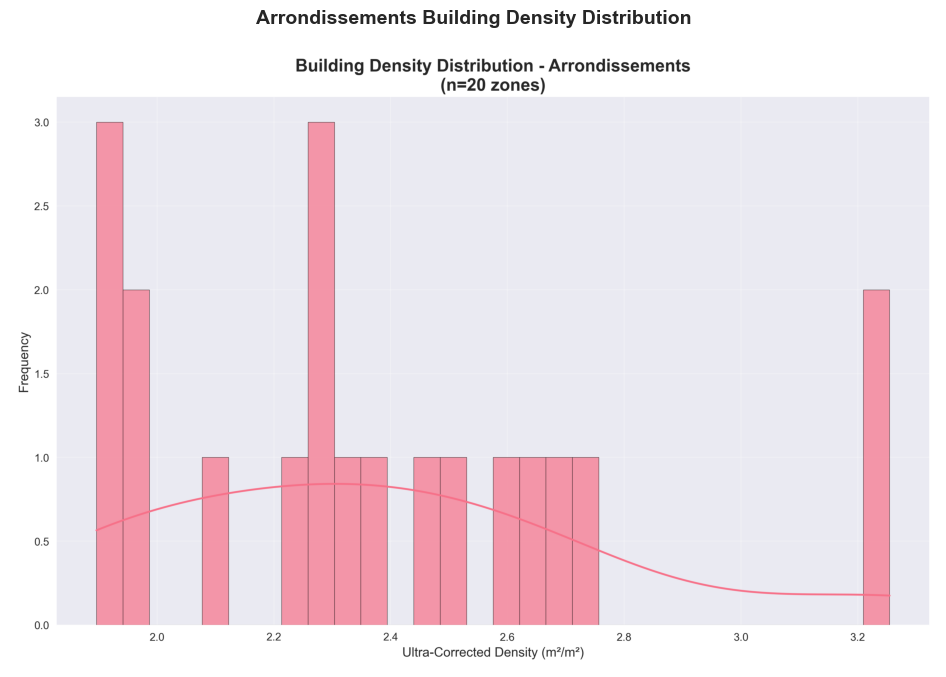

In [23]:
# Display arrondissements density histogram
img = mpimg.imread('plots/density_histogram_arrondissements.png')
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title('Arrondissements Building Density Distribution', fontsize=14, fontweight='bold', pad=20)
plt.show()

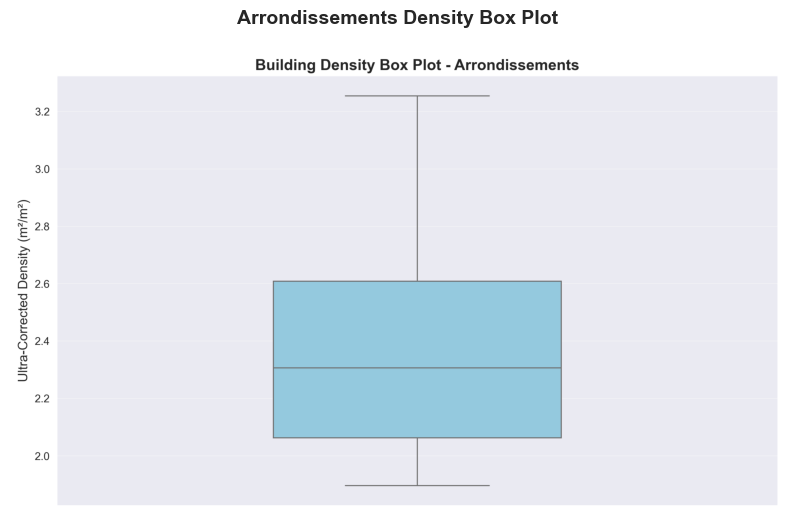

In [24]:
# Display arrondissements density box plot
img = mpimg.imread('plots/density_boxplot_arrondissements.png')
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Arrondissements Density Box Plot', fontsize=14, fontweight='bold', pad=20)
plt.show()

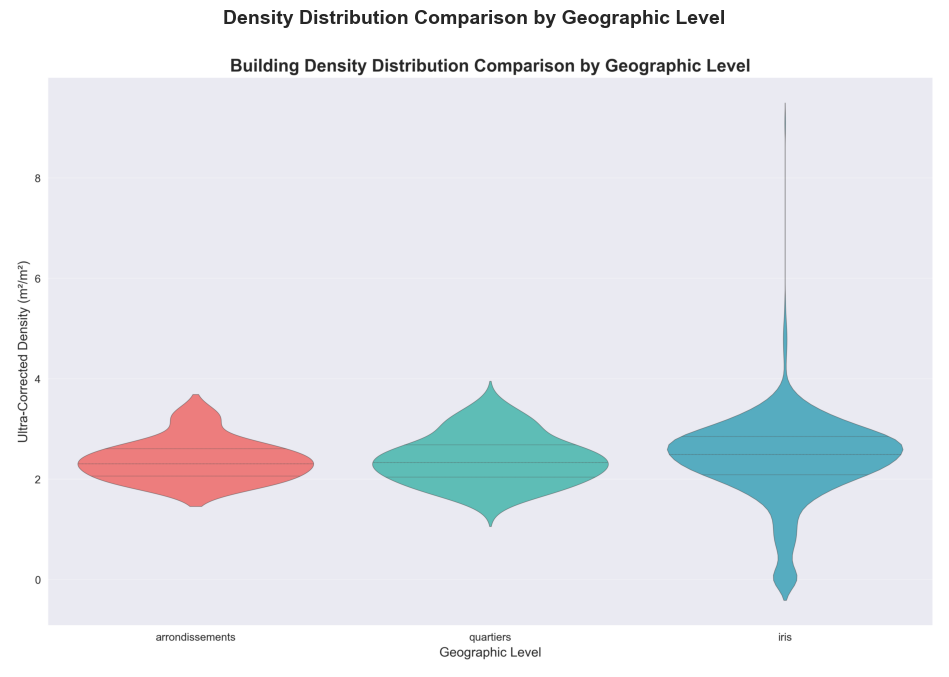

In [25]:
img = mpimg.imread('plots/density_violin_comparison.png')
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title('Density Distribution Comparison by Geographic Level', fontsize=14, fontweight='bold', pad=20)
plt.show()

Ces graphiques nous montrent quelques points intéressants:

1/ **tendance centrale**: toutes les échelles montrer un cluster autour de 2.3 - 2.4 m²/m² ce qui indique une densitée urbaine relatiement stable au niveau de la ville

2/ **variabilité**: les iris montrent uen distribution plus étirée comme discuté précedemment et montrent des valeurs extrêmes "outliers"

### Composition des zones urbaines

**Proportion de zones constructibles**:

La part non-constructible d'un arrondissement nous donne des indices sur la politique d'urbanisme de celui-ci en particulier lorsque l'espace est occupé par des ilôts ou grands parcs verts.

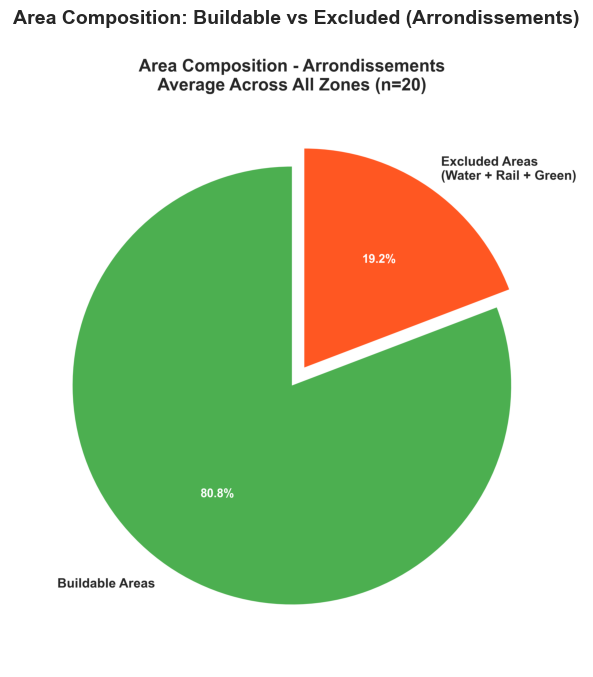

In [26]:
# Display area composition pie chart for arrondissements
img = mpimg.imread('plots/area_composition_pie_arrondissements.png')
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title('Area Composition: Buildable vs Excluded (Arrondissements)', fontsize=14, fontweight='bold', pad=20)
plt.show()

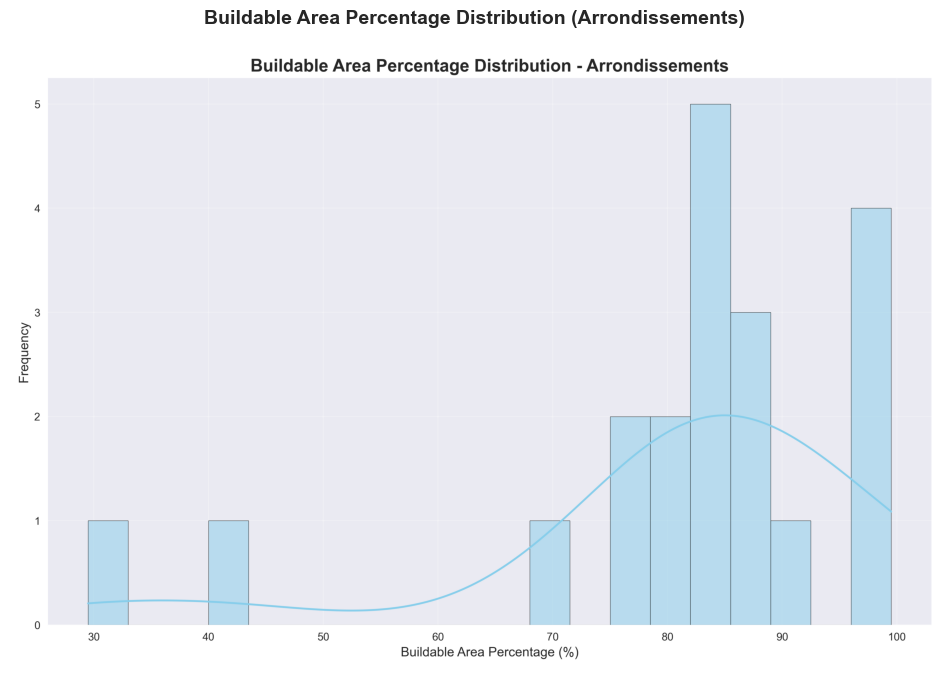

In [27]:
# Display buildable percentage distribution
img = mpimg.imread('plots/buildable_percentage_dist_arrondissements.png')
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title('Buildable Area Percentage Distribution (Arrondissements)', fontsize=14, fontweight='bold', pad=20)
plt.show()

On remarque qu'en moyenne 19.2% de la surface des arrondissements est occupée par des espaces non batissables. La distribution entre les arrondissements montre tout de même la présence de cas extrêmes: les arrondissements contenant les bois parisiens.

### Relations entre la densité et les autres métriques

On peut s'intéresser au lien entre densité du bâti et le % de surface disponible au sol. Ceci nous donnera une information importante:

Est-ce que tous les arrondissements parisiens optimisent la surface disponible de la même façon. C'est à dire, est-ce qu'on observe la même quantité de routes et le même nombre d'étages dans/autour des batiments parisiens?

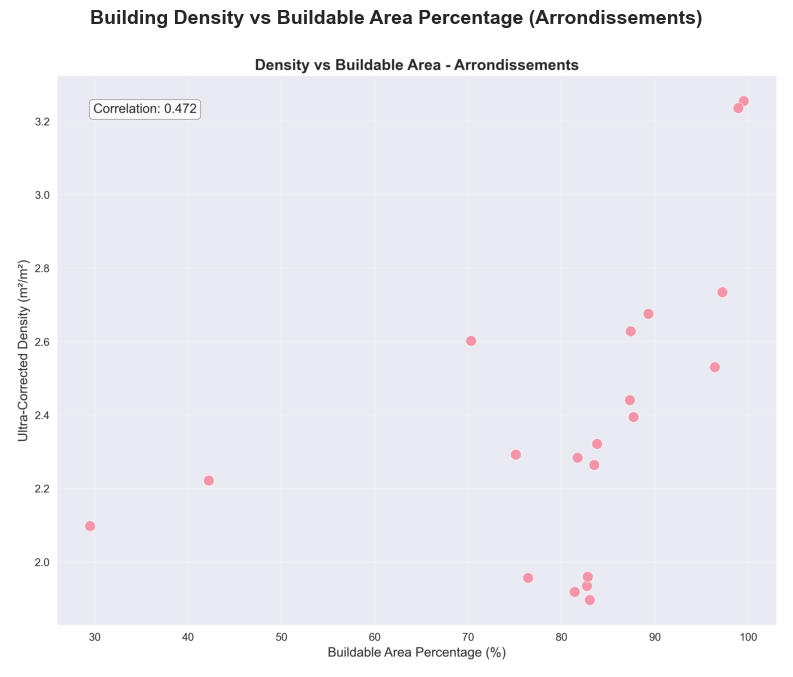

In [31]:
# Display density vs buildable area scatter plot
img = mpimg.imread('plots/density_vs_buildable_arrondissements.png')
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title('Building Density vs Buildable Area Percentage (Arrondissements)', fontsize=14, fontweight='bold', pad=20)
plt.show()

Ce graphique nous montre que non, on n'observe pas de relation linéaireentre la surface construtible et la densité du bâti. Ce point est **particulièrement intéressant** pour nous puisqu'il laisse présager des startégies différentes entre les arrondissements sur la gestion de la voirie et donc des solutions de transport.

**Correlations**:

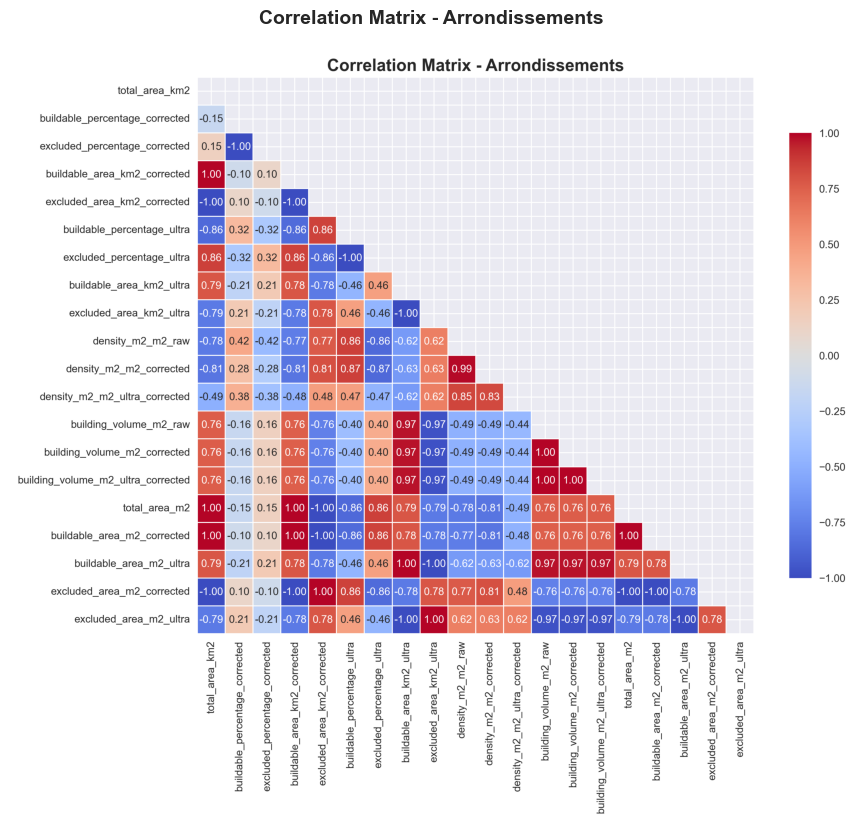

In [32]:
# Display correlation heatmap for arrondissements
img = mpimg.imread('plots/correlation_heatmap_arrondissements.png')
plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis('off')
plt.title('Correlation Matrix - Arrondissements', fontsize=14, fontweight='bold', pad=20)
plt.show()

Cette matrice de corrélation nous montre que **en général la taille totale d'un arrondissement ne montre pas une très forte corrélation avec la densité corrigée**. Ce point lié au résultat précédent laisse présager que les grands arrondissements sont plus libres d'étaler leurs constructions et de construire plus petit.

**Quelques zones particulèrement denses**

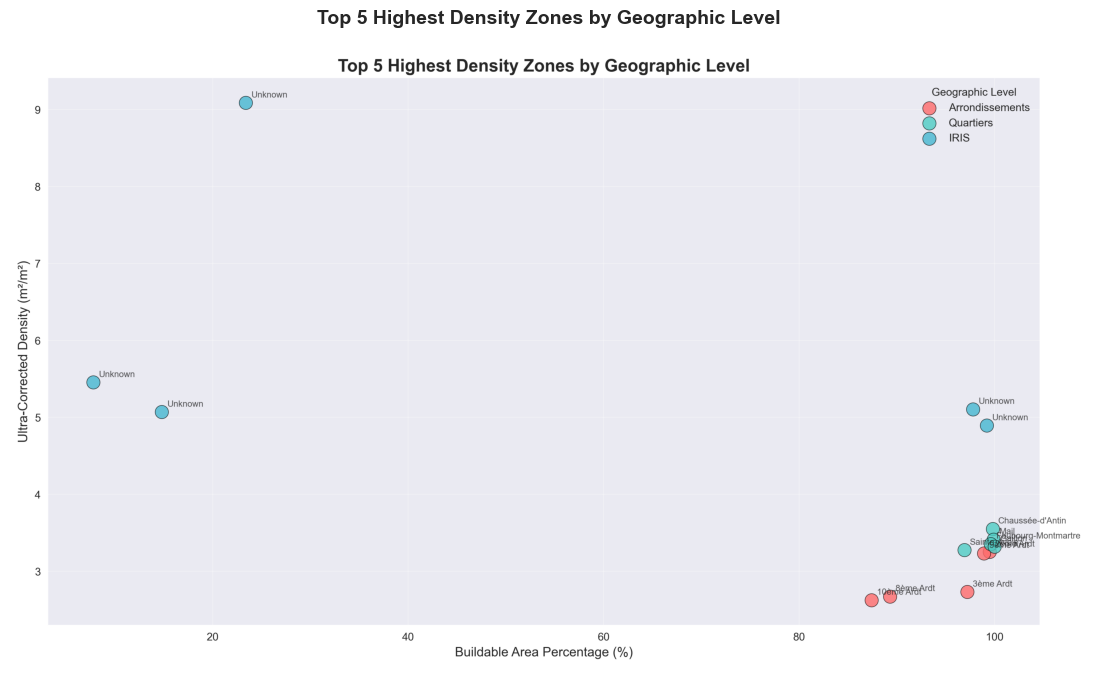

TOP 5 DENSITY ZONES BY LEVEL:

ARRONDISSEMENTS:
 2. 2ème Ardt - 3.255 m²/m² (99.5% buildable)
 9. 9ème Ardt - 3.235 m²/m² (98.9% buildable)
 3. 3ème Ardt - 2.734 m²/m² (97.2% buildable)
 8. 8ème Ardt - 2.675 m²/m² (89.3% buildable)
10. 10ème Ardt - 2.628 m²/m² (87.4% buildable)

QUARTIERS:
34 - Chaussée-d'Antin - 3.552 m²/m² (99.8% buildable)
7 - Mail - 3.414 m²/m² (99.9% buildable)
35 - Faubourg-Montmartre - 3.357 m²/m² (99.6% buildable)
5 - Gaillon - 3.323 m²/m² (100.0% buildable)
12 - Sainte-Avoie - 3.278 m²/m² (96.9% buildable)

IRIS:
804 - Unknown - 9.087 m²/m² (23.4% buildable)
931 - Unknown - 5.456 m²/m² (7.8% buildable)
279 - Unknown - 5.106 m²/m² (97.8% buildable)
529 - Unknown - 5.072 m²/m² (14.8% buildable)
490 - Unknown - 4.896 m²/m² (99.2% buildable)


In [36]:
# Display top density zones analysis
img = mpimg.imread('plots/top_density_zones.png')
plt.figure(figsize=(14, 8))
plt.imshow(img)
plt.axis('off')
plt.title('Top 5 Highest Density Zones by Geographic Level', fontsize=14, fontweight='bold', pad=20)
plt.show()

# Display top zones in tabular format
print("TOP 5 DENSITY ZONES BY LEVEL:")
print("=" * 50)

density_col = 'density_m2_m2_ultra_corrected'

# Top arrondissements
top_arr = arr_df.nlargest(5, density_col)[['arr_id', 'arr_name', density_col, 'buildable_percentage_ultra']]
print("\nARRONDISSEMENTS:")
for _, row in top_arr.iterrows():
    print(f"{int(row['arr_id']):2d}. {row['arr_name']} - {row[density_col]:.3f} m²/m² ({row['buildable_percentage_ultra']:.1f}% buildable)")

# Top quartiers
top_quartiers = quartiers_df.nlargest(5, density_col)[['quartier_id', 'quartier_name', density_col, 'buildable_percentage_ultra']]
print("\nQUARTIERS:")
for _, row in top_quartiers.iterrows():
    print(f"{row['quartier_id']} - {row['quartier_name']} - {row[density_col]:.3f} m²/m² ({row['buildable_percentage_ultra']:.1f}% buildable)")

# Top IRIS
top_iris = iris_df.nlargest(5, density_col)[['iris_code', 'iris_name', density_col, 'buildable_percentage_ultra']]
print("\nIRIS:")
for _, row in top_iris.iterrows():
    print(f"{row['iris_code']} - {row['iris_name']} - {row[density_col]:.3f} m²/m² ({row['buildable_percentage_ultra']:.1f}% buildable)")

### Résumé densité
Avec les données de la ville de Paris nous avons pu créer des **cartes** de densité du bâti (net des espaces non constructibles) et établie quelques **faits stylisés** sur la densité du bâti:
- **concentration** de la densité du bâti autour d'une valeur centrale, les arrondissements **centraux** tendent à être **plus denses** mais l'**échelle** est très **importante** car une granularité plus fine montre une réalité plus nuancée** 

Nous pourrons comparer ces cartes et faits à différentes données de qualité de transport/ de vie dans la capitale. Si les mêmes paterns se répètent nous arons alors un intérêt à creuser les liens les unissant.